# Predict Customer Lifetime Value 

### Libraries

In [41]:
# Working directory
import os
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: c:\Users\fquet\Documents\TRAVAIL\Travail_personnel\Projet_Vuciliette\notebooks


In [42]:
# Libraries 
import numpy as np
import pandas as pd 
import sklearn as sk

# Data
sales=pd.read_csv(r"C:\Users\fquet\Documents\TRAVAIL\Travail_personnel\Projet_Vuciliette\data\raw\sales.csv") # features
customer_CLV=pd.read_csv(r"C:\Users\fquet\Documents\TRAVAIL\Travail_personnel\Projet_Vuciliette\data\intermediate\CLV_data.csv") # target variable

### Data

In [43]:
print(sales.head())

# idem pour customer_CLV
customer_CLV.head()
customer_CLV.info()

  Client_ID  Year  Nb_Purchases  Tot_Purchases  Yearly_Satisfaction  Churn  \
0   C-00001  2020             4     421.877877             5.000000      0   
1   C-00001  2021             2     287.682213             5.000000      0   
2   C-00001  2022             4    1048.807532             5.000000      0   
3   C-00001  2023             2      39.947007             0.433520      1   
4   C-00002  2020             2     234.262360             4.004101      0   

  Last_Purchase First_Purchase_Next First_Purchase_AllTime  Recency  Tenure  
0    2020-08-28          2021-05-07             2020-01-23    252.0   344.0  
1    2021-11-03          2022-01-10             2020-01-23     68.0   709.0  
2    2022-11-21          2023-08-28             2020-01-23    280.0  1074.0  
3    2023-10-31                 NaN             2020-01-23    428.0  1439.0  
4    2020-10-19          2021-04-11             2020-03-05    174.0   302.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries

In [44]:
# Keep purchases for the analysis year
y_analysis=2024
sales_2024=sales[sales['Year']==y_analysis]

# Only keep active customers in 2024
sales_2024_known=sales_2024.merge(customer_CLV, on='Client_ID', how='left')

# Remove customers with unknown recency (people who never purchased)
sales_2024_known=sales_2024_known[sales_2024_known['Recency'].notna()]

# Feature engineering: average purchase value
sales_2024_known["avg_purchase"]=np.where(sales_2024_known["Nb_Purchases"]>0, sales_2024_known["Tot_Purchases"]/sales_2024_known["Nb_Purchases"], 0)

# Descriptive statistics
sales_2024_known.describe()

,Year,Nb_Purchases,Tot_Purchases,Yearly_Satisfaction,Churn,Recency,Tenure,CLV,avg_purchase
count,4874.0,4874.000000,4874.000000,4874.000000,4874.000000,4874.000000,4874.000000,4874.000000,4874.000000
mean,2024.0,3.321297,659.647492,3.857251,0.054575,244.381206,1723.900903,8915.032263,178.832668
std,0.0,2.159020,1021.452974,1.578178,0.227173,159.352706,89.275223,9032.673721,198.815735
min,2024.0,1.000000,5.821888,0.002964,0.000000,1.000000,1462.000000,211.627539,3.601235
25%,2024.0,2.000000,133.280611,2.741007,0.000000,115.000000,1672.000000,2722.436379,61.529919
50%,2024.0,3.000000,340.343015,5.000000,0.000000,212.000000,1751.000000,5522.164708,118.655932
75%,2024.0,4.000000,771.427791,5.000000,0.000000,359.000000,1796.000000,12061.215692,218.577920
max,2024.0,19.000000,18152.285255,5.000000,1.000000,726.000000,1827.000000,76882.218579,3222.467346


## Exploratory analysis

<Axes: xlabel='avg_purchase', ylabel='Proportion'>

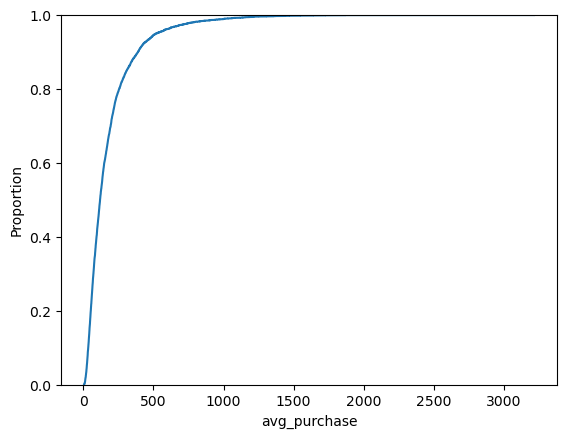

In [45]:
sales_2024_known.describe()
# 12k customers, 3k left btw 2020 and 2024 included
# 5% of customers are expected to leave after 2025 : 
# Statistical test if the proportion of churned customers in 2025 is close to 5%
prop_hat=np.mean(sales_2024_known["Churn"])
p_0=0.05
n=len(sales_2024_known["Churn"])
Z=(prop_hat - p_0)/np.sqrt(p_0*(1-p_0)/n)
from scipy.stats import norm
p_value=2*(1-norm.cdf(np.abs(Z)))
p_value
# We cannot reject, p=0.05 churn rate is plausible

# On average, customers spend 60€ per year 
mu_hat=np.mean(sales_2024_known["Tot_Purchases"])
n=len(sales_2024_known["Tot_Purchases"])
sigma_hat=np.std(sales_2024_known["Tot_Purchases"], ddof=1)
phi=(mu_hat - 60)/(sigma_hat/np.sqrt(n))
p_value=2*(1-norm.cdf(np.abs(phi)))
p_value

# Parmi les churneurs, la dépense moyenne est-elle inférieure à celle des non-churneurs ?
sales_2024_known.groupby("Churn")["avg_purchase"].mean()
# Test de Welch
from scipy.stats import ttest_ind
g1=sales_2024_known[sales_2024_known["Churn"]==1]["avg_purchase"]
g2=sales_2024_known[sales_2024_known["Churn"]==0]["avg_purchase"]
t_stat, p_val = ttest_ind(g1, g2, equal_var=False,alternative="less")
t_stat, p_val
# We reject the null hypothesis, the average purchase of churners is significantly lower than that of non-churners

# Plot distribution of avg_purchase 
import matplotlib.pyplot as plt
import seaborn as sns
# plt.hist(sales_2024_known["avg_purchase"], bins=50)
# plt.xlabel("Average Purchase Value")
# Draw cumulative distribution
sns.ecdfplot(sales_2024_known["avg_purchase"])

## Predictive modeling

In [46]:
# Predictive modeling
from sklearn.model_selection import train_test_split
X=sales_2024_known[["Nb_Purchases","avg_purchase","Recency","Tenure"]]
y=sales_2024_known["CLV"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test.describe()

# Random Forest Regressor 
# Car gère bien les gros jeu de données et les variables non linéaires, peu de pré-traitement nécessaire,
# peu couteux en temps de calcul, possibilité d'interprétation via l'importance des variables
# pas besoin de standardiser
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

model1_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model1_rf.fit(X_train, y_train)

# To evaluate the model
y_pred_model1 = model1_rf.predict(X_test)

In [47]:
# Performance evaluation
from sklearn.metrics import mean_squared_error, r2_score
y_pred_model1_train = model1_rf.predict(X_train)
mse_model1_train = mean_squared_error(y_train, y_pred_model1_train)
rmse_model1_train = np.sqrt(mse_model1_train)
r2_model1_train = r2_score(y_train, y_pred_model1_train)
mse_model1_test = mean_squared_error(y_test, y_pred_model1)
r2_model1 = r2_score(y_test, y_pred_model1)
rmse_model1 = np.sqrt(mean_squared_error(y_test, y_pred_model1))
print(f"RMSE Model 1: {rmse_model1}")
print(f"Mse Model 1: {mse_model1_test}")
print(f"R2 Model 1: {r2_model1}")
# On the train set
print(f"RMSE Model 1 Train: {rmse_model1_train}")
print(f"Mse Model 1 Train: {mse_model1_train}")
print(f"R2 Model 1 Train: {r2_model1_train}")

# Le R² est négatif, le modèle ne parvient pas à capturer la variance de la variable cible.
# La MSE semble élevée mais il faudrait lui associer une intérprétation business
# La variance de la variable cible est 209k ici MSE 265k 
# Une prédiction supérieure de +500€ est jugée grave car l'objectif business est de cibler les clients qui seront là longtemps pour les gâter à Noël avec une 
# campagne marketing spéciale

# Trop de cas de sur-prédiction sérieuse, le modèle n'est pas utilisable en l'état


RMSE Model 1: 7419.027569098823
Mse Model 1: 55041970.071048394
R2 Model 1: 0.24495555248763123
RMSE Model 1 Train: 2898.4128148298423
Mse Model 1 Train: 8400796.84516985
R2 Model 1 Train: 0.8996774435081571


In [48]:
y.describe()

count     4874.000000
mean      8915.032263
std       9032.673721
min        211.627539
25%       2722.436379
50%       5522.164708
75%      12061.215692
max      76882.218579
Name: CLV, dtype: float64

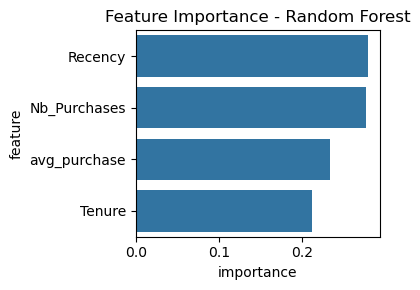

In [201]:
# Feature importance
fi = pd.DataFrame({
    "feature": X.columns,
    "importance": model1_rf.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(4, 3))
sns.barplot(data=fi, x="importance", y="feature")
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()

In [202]:
# Results of the model
results=pd.DataFrame({
    "Actual_CLV": y_test,
    "Predicted_CLV": y_pred_model1
})
print(results)

results["Overprediction"] = np.where(results["Actual_CLV"] - results["Predicted_CLV"]>0,
                                     "Underprediction",
                                     np.where(results['Predicted_CLV'] - results['Actual_CLV']>1000,
                                              "Serious_Overprediction",
                                              "Slight_Overprediction"))

results["Overprediction"].groupby(results["Overprediction"]).describe()


        Actual_CLV  Predicted_CLV
1173  37881.166710   12631.517943
160    9506.442694    8720.602418
2609  12881.715299    3440.138369
203   10626.956264   14851.211944
2836  30320.566343   28344.706470
...            ...            ...
720   29283.443382   15648.597502
4348  15974.682945   10526.988587
996    2066.384064    5659.550540
3927   9419.574483   10700.820549
2160  10262.537503    7613.051246

[842 rows x 2 columns]


,count,unique,top,freq
Overprediction,,,,
Serious_Overprediction,423,1,Serious_Overprediction,423
Slight_Overprediction,70,1,Slight_Overprediction,70
Underprediction,349,1,Underprediction,349


In [203]:
# Modèle naif : prédire la moyenne
y_pred_naive= np.full(shape=y_test.shape, fill_value=np.mean(y_train))
mse_naive = mean_squared_error(y_test, y_pred_naive)
r2_naive = r2_score(y_test, y_pred_naive)
print(f"Mse Naive Model: {mse_naive}")
print(f"R2 Naive Model: {r2_naive}")

# Autre métrique : MAE
from sklearn.metrics import mean_absolute_error
mae_model1 = mean_absolute_error(y_test, y_pred_model1)
mae_naive = mean_absolute_error(y_test, y_pred_naive)
print(f"MAE Model 1: {mae_model1}")
print(f"MAE Naive Model: {mae_naive}")

# Autre métrique très utilisée en business : MAPE
from sklearn.metrics import mean_absolute_percentage_error
mape_model1 = mean_absolute_percentage_error(y_test, y_pred_model1)
mape_naive = mean_absolute_percentage_error(y_test, y_pred_naive)
print(f"MAPE Model 1: {mape_model1}")
print(f"MAPE Naive Model: {mape_naive}")

# Métrique la plus utilisée en business : RMSE
from sklearn.metrics import mean_squared_error
rmse_model1 = np.sqrt(mean_squared_error(y_test, y_pred_model1))
rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))
print(f"RMSE Model 1: {rmse_model1}")
print(f"RMSE Naive Model: {rmse_naive}")

Mse Naive Model: 97991359.09833498
R2 Naive Model: -0.006010040968298602
MAE Model 1: 5898.400056261886
MAE Naive Model: 7143.559729955356
MAPE Model 1: 0.9375996203852361
MAPE Naive Model: 1.4125630842192416
RMSE Model 1: 8433.576544652558
RMSE Naive Model: 9899.058495550726


## Modèle 2

In [ ]:
# Model 2 : XGBoost Regressor
import xgboost as xgb
model2_xgb = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, random_state=42)
model2_xgb.fit(X_train, y_train)

y_pred_model2 = model2_xgb.predict(X_test)

# Evaluate the model
mse_model2 = mean_squared_error(y_test, y_pred_model2)
mae_model2=mean_absolute_error(y_test, y_pred_model2)
r2_model2 = r2_score(y_test, y_pred_model2)
rmse_model2 = np.sqrt(mean_squared_error(y_test, y_pred_model2))
print(f"MAE Model 2: {mae_model2}")
print(f"RMSE Model 2: {rmse_model2}")
print(f"Mse Model 2: {mse_model2}")
print(f"R2 Model 2: {r2_model2}")

MAE Model 2: 6191.965981007301
MAE Check Model 2: 6191.965981007301
RMSE Model 2: 8886.998258611044
Mse Model 2: 78978738.04855572
R2 Model 2: 0.18917949265179557


# Modèle 3 : regréssion linéaire classique

In [210]:
# Model 3 : linear regression
from sklearn.linear_model import LinearRegression
model3_lr = LinearRegression()
model3_lr.fit(X_train, y_train)
y_pred_model3 = model3_lr.predict(X_test)
# Evaluate the model
mse_model3 = mean_squared_error(y_test, y_pred_model3)
r2_model3 = r2_score(y_test, y_pred_model3)
rmse_model3= np.sqrt(mean_squared_error(y_test, y_pred_model3))
mae_model3=mean_absolute_error(y_test, y_pred_model3)
print(f"MAE Model 3: {mae_model3}")
print(f"RMSE Model 3: {rmse_model3}")
print(f"Mse Model 3: {mse_model3}")
print(f"R2 Model 3: {r2_model3}")

MAE Model 3: 5915.172308336013
RMSE Model 3: 8368.124534772367
Mse Model 3: 70025508.22945926
R2 Model 3: 0.28109615938635113


## Comparaison des modèles

count      842.000000
mean     10556.364608
std       9875.310980
min        570.776307
25%       3706.490268
50%       7051.043776
75%      14502.181739
max      76882.218579
Name: CLV, dtype: float64
count      842.000000
mean      5898.400056
std       6031.359179
min          6.020261
25%       1855.193302
50%       4217.744367
75%       7841.350551
max      59739.263169
Name: CLV, dtype: float64


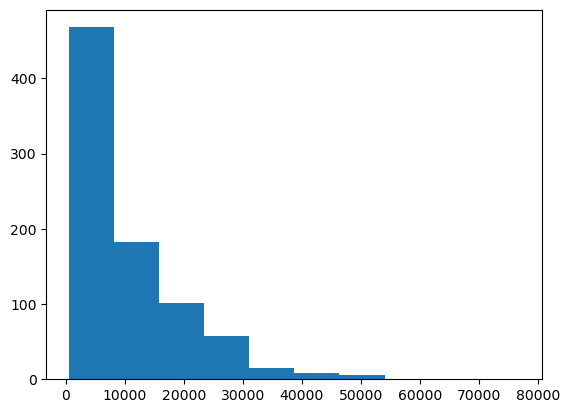

In [221]:
plt.hist(y_test,bins=10,density=False)
print(y_test.describe())
print(np.abs(y_test - y_pred_model1).describe())

In [212]:
# Compare models
print(f"L'écart-type du test np.std(y_test): {np.std(y_test)}")
model_comparison = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "Linear Regression", "BG/NBD + Gamma-Gamma"],
    "RMSE": [rmse_model1, rmse_model2, rmse_model3, "env. 14000"],
    "MAE": [mae_model1, mae_model2, mae_model3, "à refaire"],
    "R2": [r2_model1, r2_model2, r2_model3, "à refaire"]
})
model_comparison

L'écart-type du test np.std(y_test): 9869.445038910182


,Model,RMSE,MAE,R2
0,Random Forest,8433.576545,5898.400056,0.269806
1,XGBoost,8886.998259,6191.965981,0.189179
2,Linear Regression,8368.124535,5915.172308,0.281096
3,BG/NBD + Gamma-Gamma,env. 14000,à refaire,à refaire
